In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import sys
import os
sys.path.insert(0, os.path.abspath("."))
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import numpy as np

from lib.training_utils import translate_text
from lib.metrics import compute_bleu, compute_comet
from lib.preprocessing import preprocess_data

# Load backtranslation model and generate n predictions

In [3]:
baseline_model_name = "Helsinki-NLP/opus-mt-ru-en"
checkpoint_path = "Helsinki-NLP/opus-mt-ru-en"

In [5]:
tokenizer = AutoTokenizer.from_pretrained(baseline_model_name)
bt_model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_path)

In [59]:
def translate_text_n_samples(
    texts: list[str],
    model: AutoModelForSeq2SeqLM,
    tokenizer: AutoTokenizer,
    batch_size: int = 32,
    max_length: int = 128,
    n_samples: int = 5,
    temperature: float = 1.0,
    num_beams: int = 4,
    top_k: int | None = None,
    top_p: float | None = None,
):
    """Translate *texts* and return *n_samples* random hypotheses per input.

    **Speed‑up trick** ➜ **batch the *n_samples* dimension**.
    Instead of calling ``generate`` *n_samples* times, we *tile* each input
    ``n_samples`` times and make **one** call.  This re‑uses the encoder pass and
    scales much better for large batches (e.g. 128 sources × 5 samples ➜ 640
    sequences in a single forward pass).

    Returned structure: ``List[List[str]]`` where the inner list holds the
    ``n_samples`` hypotheses for that source sentence.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    model = model.to(device)
    model.eval()

    all_translations: list[list[str]] = []

    for start in tqdm(range(0, len(texts), batch_size), desc="Translating"):
        batch = texts[start:start + batch_size]
        enc = tokenizer(
            batch,
            return_tensors="pt",
            max_length=max_length,
            truncation=True,
            padding=True,
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        # ----  B  A  T  C  H   N  _  S  A  M  P  L  E  S  ----
        # Repeat each row of the batch n_samples times so the model sees
        # (batch_size × n_samples) inputs in one go.
        enc = {k: v.repeat_interleave(n_samples, dim=0) for k, v in enc.items()}

        with torch.no_grad():
            out = model.generate(
                **enc,
                max_length=max_length,
                temperature=temperature,
                do_sample=True,
                num_beams=num_beams,
                num_return_sequences=1,    # still one best per *replicated* input
                top_k=(top_k or 0),         # 0 disables top‑k
                top_p=(top_p or 1.0),       # 1.0 disables top‑p
                early_stopping=True,
            )

        decoded = tokenizer.batch_decode(out, skip_special_tokens=True)

        # regroup: every contiguous n_samples belong to the same source sentence
        it = iter(decoded)
        batch_samples = [list(next(it) for _ in range(n_samples)) for _ in batch]
        all_translations.extend(batch_samples)

    return all_translations

In [60]:
translate_text_n_samples(
    texts=["Привет, как дела?", "Какой сегодня день?"],
    model=bt_model,
    tokenizer=tokenizer,
    n_samples=3
)

Using device: cuda


Translating:   0%|          | 0/1 [00:00<?, ?it/s]

[['Hey, how are you?', "Hey, how's it going?", "Hey, how's it going?"],
 ['What day is today?', 'What day is today?', 'What day is today?']]

# 2. Load monolingual data for further evaluation

In [24]:
dataset = load_dataset("sethjsa/medline_ru_mono")['train']['ru']

In [27]:
translate_text_n_samples(
    texts=dataset[:5],
    model=bt_model,
    tokenizer=tokenizer,
)

Using device: cuda


Translating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


[['Summary Objective: To determine the extent to which the flu contributes to the incidence of severe acute respiratory infection (SWD) in Bangladesh, which is a major cause of childhood mortality.',
  'Summary Objective: To determine the extent to which influenza contributes to severe acute acute respiratory infection (SAR) in Bangladesh, which is the major cause of maternal mortality.',
  'Objective: To determine the extent to which influenza contributes to severe acute respiratory infection (HDR) in Bangladesh, which is the leading cause of child mortality.',
  'Summary Objective: To determine the extent to which influenza contributes to the incidence of severe acute respiratory infections (SAR) in Bangladesh, which is the leading cause of acute acute acute disease in Bangladesh and is the leading cause of maternal mortality.',
  'Summary Objective: To determine the extent to which influenza contributes to the transmission of severe acute respiratory infection (SAR) to people of all

In [30]:
class EntailmentDeberta():
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v2-xlarge-mnli")
        self.model = AutoModelForSequenceClassification.from_pretrained(
            "microsoft/deberta-v2-xlarge-mnli").to('cuda')

    def check_implication(self, text1, text2, *args, **kwargs):
        inputs = self.tokenizer(text1, text2, return_tensors="pt").to('cuda')
        # The model checks if text1 -> text2, i.e. if text2 follows from text1.
        # check_implication('The weather is good', 'The weather is good and I like you') --> 1
        # check_implication('The weather is good and I like you', 'The weather is good') --> 2
        outputs = self.model(**inputs)
        logits = outputs.logits
        # Deberta-mnli returns `neutral` and `entailment` classes at indices 1 and 2.
        largest_index = torch.argmax(F.softmax(logits, dim=1))  # pylint: disable=no-member
        prediction = largest_index.cpu().item()

        return prediction

In [31]:
entailment = EntailmentDeberta()

tokenizer_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/952 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.45M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.77G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.77G [00:00<?, ?B/s]

In [45]:
def get_semantic_ids(strings_list, entailment_model, strict_entailment=False, example=None):
    """Group list of predictions into semantic meaning."""

    def are_equivalent(text1, text2):

        implication_1 = entailment_model.check_implication(text1, text2, example=example)
        implication_2 = entailment_model.check_implication(text2, text1, example=example)  # pylint: disable=arguments-out-of-order
        assert (implication_1 in [0, 1, 2]) and (implication_2 in [0, 1, 2])

        if strict_entailment:
            semantically_equivalent = (implication_1 == 2) and (implication_2 == 2)

        else:
            implications = [implication_1, implication_2]
            # Check if none of the implications are 0 (contradiction) and not both of them are neutral.
            semantically_equivalent = (0 not in implications) and ([1, 1] != implications)

        return semantically_equivalent

    # Initialise all ids with -1.
    semantic_set_ids = [-1] * len(strings_list)
    # Keep track of current id.
    next_id = 0
    for i, string1 in enumerate(strings_list):
        # Check if string1 already has an id assigned.
        if semantic_set_ids[i] == -1:
            # If string1 has not been assigned an id, assign it next_id.
            semantic_set_ids[i] = next_id
            for j in range(i+1, len(strings_list)):
                # Search through all remaining strings. If they are equivalent to string1, assign them the same id.
                if are_equivalent(string1, strings_list[j]):
                    semantic_set_ids[j] = next_id
            next_id += 1

    assert -1 not in semantic_set_ids

    return semantic_set_ids

def cluster_assignment_entropy(semantic_ids):
    """Estimate semantic uncertainty from how often different clusters get assigned.

    We estimate the categorical distribution over cluster assignments from the
    semantic ids. The uncertainty is then given by the entropy of that
    distribution. This estimate does not use token likelihoods, it relies soley
    on the cluster assignments. If probability mass is spread of between many
    clusters, entropy is larger. If probability mass is concentrated on a few
    clusters, entropy is small.

    Input:
        semantic_ids: List of semantic ids, e.g. [0, 1, 2, 1].
    Output:
        cluster_entropy: Entropy, e.g. (-p log p).sum() for p = [1/4, 2/4, 1/4].
    """

    n_generations = len(semantic_ids)
    counts = np.bincount(semantic_ids)
    probabilities = counts/n_generations
    assert np.isclose(probabilities.sum(), 1)
    entropy = - (probabilities * np.log(probabilities)).sum()
    return entropy

In [46]:
get_semantic_ids(
    ["I love Poland because it is a beautiful country",
     "I really like Poland because it is a beautiful country",
     "I love Czechia because it is a beautiful country",
     "I hate living in Poland",
    ],
    entailment_model=entailment,
)


[0, 0, 1, 2]

In [49]:
cluster_assignment_entropy(
    [0, 1, 0, 2]
)

1.0397207708399179

In [69]:
translations = translate_text_n_samples(
    texts=dataset[:100],
    model=bt_model,
    tokenizer=tokenizer,
    n_samples=5,
    batch_size=64
) # 24.4s for 100 samples, for 30_000 samples it's 300 * 25s = around 2h

Using device: cuda


Translating:   0%|          | 0/2 [00:00<?, ?it/s]

In [70]:
translations

[['Goal: To determine the extent to which influenza contributes to severe acute respiratory infection (SID) in Bangladesh, which is the leading cause of child mortality.',
  'Objective: To determine the extent to which influenza contributes to the incidence of severe acute respiratory infections (SAR) in Bangladesh, which is the leading cause of death.',
  'Summary Objective: To determine the extent to which the flu contributes to the incidence of severe acute respiratory infection (SAR) in Bangladesh, which is the leading cause of infant mortality.',
  'Summary Objective: To determine the extent to which influenza contributes to severe acute respiratory infection (SAR) in Bangladesh, which is the main cause of child mortality and is responsible for its loss.',
  'Summary Objective: To determine the extent to which influenza contributes to acute acute respiratory infection (SAR) in Bangladesh, which is the main cause of death in Bangladesh.'],
 ['Methods: Doctors took nose and sores fo

In [71]:
# calculate semantic entropy for each sample

semantic_ids = []

for i in tqdm(range(len(translations)), desc="Calculating semantic ids"):
    # Get semantic ids for each sample
    semantic_ids.append(get_semantic_ids(translations[i], entailment_model=entailment))
    
# calculate semantic entropy for each sample
semantic_entropies = []
for i in tqdm(range(len(semantic_ids)), desc="Calculating semantic entropies"):
    # Get semantic ids for each sample
    semantic_entropies.append(cluster_assignment_entropy(semantic_ids[i]))


Calculating semantic ids:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating semantic entropies:   0%|          | 0/100 [00:00<?, ?it/s]

In [72]:
semantic_entropies

[0.5004024235381879,
 0.5004024235381879,
 0.6730116670092565,
 0.9502705392332347,
 1.0549201679861442,
 1.3321790402101223,
 0.5004024235381879,
 -0.0,
 -0.0,
 -0.0,
 0.5004024235381879,
 1.0549201679861442,
 -0.0,
 1.6094379124341005,
 0.9502705392332347,
 -0.0,
 1.3321790402101223,
 0.6730116670092565,
 0.5004024235381879,
 1.0549201679861442,
 1.0549201679861442,
 0.5004024235381879,
 0.5004024235381879,
 1.3321790402101223,
 1.0549201679861442,
 1.6094379124341005,
 0.5004024235381879,
 1.3321790402101223,
 0.9502705392332347,
 1.0549201679861442,
 1.0549201679861442,
 1.0549201679861442,
 -0.0,
 0.5004024235381879,
 1.3321790402101223,
 -0.0,
 0.5004024235381879,
 -0.0,
 0.5004024235381879,
 1.3321790402101223,
 0.6730116670092565,
 1.6094379124341005,
 -0.0,
 1.0549201679861442,
 0.5004024235381879,
 -0.0,
 0.9502705392332347,
 0.9502705392332347,
 0.5004024235381879,
 0.5004024235381879,
 -0.0,
 -0.0,
 1.6094379124341005,
 0.5004024235381879,
 1.3321790402101223,
 -0.0,
 -0.0,

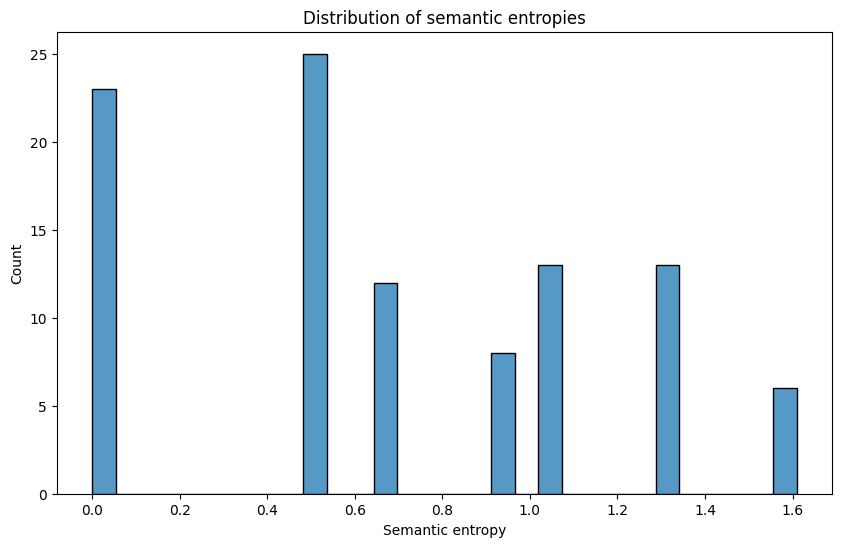

In [73]:
# plot a distribution of semantic entropies
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(semantic_entropies, bins=30)
plt.xlabel("Semantic entropy")
plt.ylabel("Count")
plt.title("Distribution of semantic entropies")
plt.show()

In [74]:
# Create huggingface datasetdict with "train", then languages "ru", "en", "all_en_generations", "semantic_ids", "semantic_entropy"
# for "en" keep the first generation, for "all_en_generations" keep all generations

from datasets import DatasetDict, Dataset
dataset_dict = DatasetDict()

dataset_dict['train'] = Dataset.from_dict({
    'ru': dataset[:100],
    'en': [translation[0] for translation in translations],
    'all_en_generations': translations,
    'semantic_ids': semantic_ids,
    'semantic_entropy': semantic_entropies
})

In [ ]:
# save under given directory
save_path = 

# save

Dataset({
    features: ['ru', 'en', 'all_en_generations', 'semantic_ids', 'semantic_entropy'],
    num_rows: 100
})